In [1]:
%load_ext autoreload
%autoreload 2
%pdb on

Automatic pdb calling has been turned ON


# Check cage deformation

In [14]:
from IPython.display import display
import sys
import os
sys.path.append(os.path.join(os.curdir, ".."))
import torch
from optimize_flame import (setup_cameras, 
                            setup_diff_renderer,
                            setup_renderer,
                            load_objs_as_meshes,
                            flame_config,
                            FlameCustom,
                            detect_symmetry,
                            deform_cage_symmetrically,
                            deform_with_MVC,
                            render_mesh_and_cage,
                            )

from pytorch3d.structures import Meshes, join_meshes_as_scene

[autoreload of optimize_flame failed: Traceback (most recent call last):
  File "/home/yifita/.virtualenvs/blender/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/yifita/.virtualenvs/blender/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/yifita/.virtualenvs/blender/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/yifita/.virtualenvs/blender/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/yifita/.virtualenvs/blender/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/yifita/.virtualenvs/blender/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345

creating the FLAME Decoder


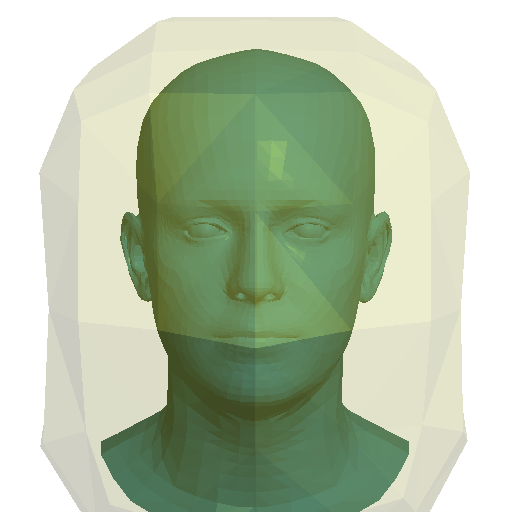

In [15]:
from PIL import Image

device = "cuda"
img_size = 512
cameras = setup_cameras(device, img_size)
mesh_renderer = setup_renderer(device, img_size, cameras)

# Create Flame model
flame_scale = 2.9
flame_transl = torch.tensor([0, 0.04, 0.12])

flame_server = FlameCustom(flame_config, scale=flame_scale, transl=flame_transl)
flame_server.to(device)
template = flame_server.v_template + flame_server.transl
template = template.unsqueeze(0)
template_og = template.clone()

# Load cage
cage_mesh = load_objs_as_meshes(["../assets/flame_cage.obj"], load_textures=False)
cage_mesh.scale_verts_(flame_scale)
cage_mesh.offset_verts_(flame_transl)
cage_mesh = cage_mesh.to(device)
cage_verts = cage_mesh.verts_padded()
cage_faces = cage_mesh.faces_padded()
cage_verts_og = cage_verts.clone()
cage_mesh_og = Meshes(cage_verts_og, cage_faces)

# Render for visualize
img = render_mesh_and_cage(mesh_renderer, cameras, Meshes(template, flame_server.faces_tensor[None]), cage_mesh)[0]
display(Image.fromarray(img))

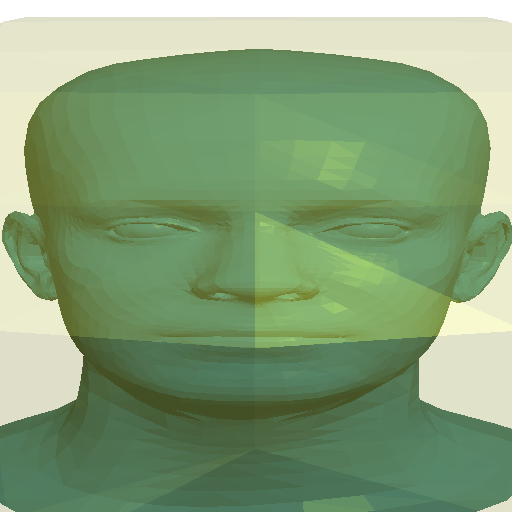

In [16]:
# Initialize cage delta
cage_delta = torch.zeros_like(cage_verts)
cage_delta[..., 0] = 0.3

# Mark cage symmetry vertices
cage_symmetry_idx = detect_symmetry(cage_verts[0])

# Deform cage symmetrically
cage_verts_d = deform_cage_symmetrically(cage_verts[0], cage_delta[0], cage_symmetry_idx)
cage_mesh = cage_mesh.offset_verts(cage_verts_d-cage_verts[0])

template = deform_with_MVC(cage_verts, cage_verts_d[None], cage_faces, template, verbose=False)

# Render for visualize
img = render_mesh_and_cage(mesh_renderer, cameras, 
                           Meshes(template, flame_server.faces_tensor[None]), 
                           cage_mesh)[0]
display(Image.fromarray(img))

# Check dataset

In [17]:
from eg3d_dataset import ImageFolderDataset as EG3DDataset
from torch.utils.data import DataLoader
import numpy as np

dataset = EG3DDataset(path="/mnt/Storage/data/FFHQ/EG3D", use_labels=True, max_size=2000, xflip=False, img_subpath="images", mask_subpath="masks")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
data_iter = iter(dataloader)


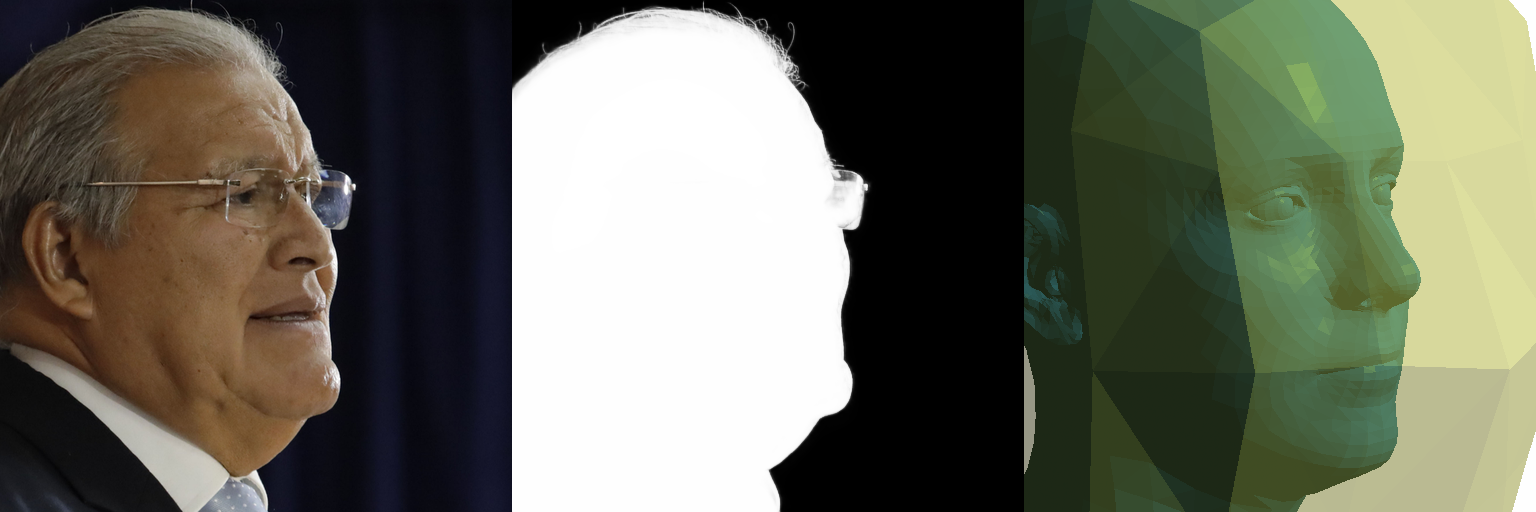

In [71]:
from optimize_flame import setup_cameras
rgb, mask, pose = next(data_iter)   
# print(rgb.shape, mask.shape, pose.shape)
# print("pose", pose)
# print("rgb", rgb.max(), rgb.min())
# print("mask", mask.max(), mask.min())
mask = 255 * mask

cameras = setup_cameras(device, img_size, pose=pose[:, :16].reshape(1, 4, 4))
img = render_mesh_and_cage(mesh_renderer, cameras,
                           Meshes(template_og, flame_server.faces_tensor[None]), 
                           Meshes(cage_verts_og, cage_faces))[0]
img_input = torch.cat([rgb.permute(0, 2, 3, 1), mask.permute(0, 2, 3, 1).expand(-1, -1, -1, 3).to(torch.uint8)], dim=2).cpu().numpy()[0]
img = np.concatenate([img_input, img[...,:3]], axis=1)
display(Image.fromarray(img))

# Test landmark detection for face and on flame

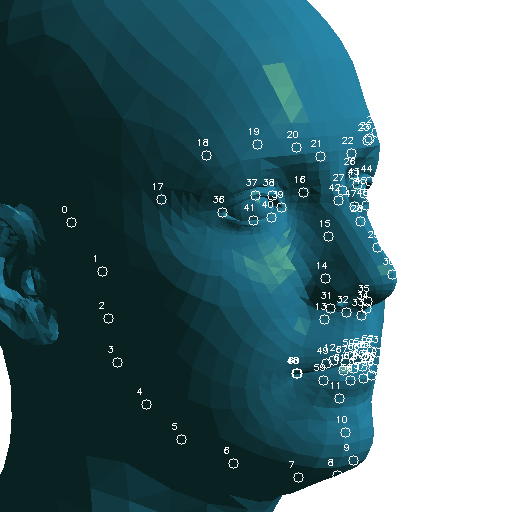

torch.Size([1, 68, 3])


In [84]:
import cv2
from optimize_flame import render_meshes
shp_params = torch.zeros((1, 100)).to(device)
exp_params = torch.zeros((1, 50)).to(device)
pose_params = torch.zeros((1, 6)).to(device)
template, lmk_3d = flame_server(shape_params=shp_params, expression_params=exp_params, pose_params=pose_params)
cameras.image_size = [[img_size, img_size]]

def project_lmk(lmk_3d):
    # transform to NDC
    return cameras.transform_points_screen(lmk_3d, with_xyflip=True)

lmk_2d = project_lmk(lmk_3d)
img = render_meshes(mesh_renderer, cameras, Meshes(template, flame_server.faces_tensor[None]))[0]

def draw_landmarks(image, lmk_2d):
    """
    Args:
        img: numpy array
        lmk_2d: a list of (x, y) coordinates
    """
    # Define circle properties
    radius = 5
    color = (255, 0, 0)  # Red
    thickness = 1  # In pixels
    # somehow cv2 only take RGBA image
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)    
        
    # Loop over the coordinates to draw circles and labels
    for index, (x, y) in enumerate(lmk_2d):
        image = cv2.circle(image, (x, y), radius, color, thickness)
        image = cv2.putText(image, str(index), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    return image


img = draw_landmarks(img, lmk_2d[0, :, :2].cpu().numpy().astype('int'))
display(Image.fromarray(img))
print(lmk_2d.shape)

In [ ]:
import face_alignment

rgb_input = rgb[0].permute(1, 2, 0).cpu().numpy()
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.THREE_D, flip_input=False)

preds = fa.get_landmarks_from_image(rgb_input)
print(preds[0].shape)

img = draw_landmarks(rgb_input, preds[0][:, :2].astype('int'))
display(Image.fromarray(img))

# Optimize global transl and scale with landmark loss

In [ ]:
import torch.nn as nn
# Set the parameters
transl_param = nn.Parameter(torch.zeros_like(flame_server.transl), requires_grad=True)
scale_param = nn.Parameter(torch.zeros((3, ), device=transl_param.device), requires_grad=True)

# Set the optimizer
optimizer = torch.optim.Adam([transl_param, scale_param], lr=0.05, momentum=0.9)

# Define losses
def lmk_loss():
    # TODO
    pass



# Render silhouette images.  The 3rd channel of the rendering output is
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]